# Practices

In the practices, we will use an opensource simulator ([MUST](https://www.biomecardio.com/MUST/) - Matlab UltraSound Toolbox) to understand how ultrasound images are generated by emmiting a forward wave from the transducer, and locatting the source of each recieved echos. The original version of MUST was developped in Matlab by Damien Garcia, but in these sessions we will use a python reimplementation, called pyMUST. The toolbox has the functions to generate B-mode and Doppler images from radiofrequencies, which can be either real or simulated. Here, we will only use simulated data. The same toolbox also allows simulating the acquisition process, for which you will have to define the characteristics of the probe and the emmited pulse, as well as the position and reflectivity of the scatterers. Here, we will only use simulated data. Using a simulation has the advantage that it allows to easily change the different parameters of the ultrasound probe, emmited wave in a completely controlled environment and study how it affects image generation. 

The practices are organised as follows, and each consists of a python notebook with a code skeleton and instructions, as well as a document with the questions. Each practice includes a 2h classroom session. After each practice, you will need to complete the report template, answering the questions, and upload it to the "Campus global".


1. *Radiofrequency (i):* Introduction to MUST, emmited and recieved signals in a single piezoelectrical element probe, probe bandwidth and center frequency, signal demodulation, attenuation.
2. *Radiofrequency (ii)*: Extension to a setting with probes of several piezoelectrical elements, different emmited waves (linear, circular, focused), time delays in transmission(emmision), pressure fields.

3. *B-mode (i)*: Generate a greyscale image from the radiofrequency: beamforming using Delay-And-Sum matrix, log-compression, image resolution.
4. *B-mode (ii): Effect of the probe to image generation: number of elements, element size, probe geometry (linear, curved, phased-array).

5. *Doppler (i):* Measure velocities of few scatterers using spectral and color (phase) Doppler. 
6. *Doppler (ii):* Measure velocities in a 2D geometry, using a synthetic rotating disk, display the velocity field as a color map in an image (color Doppler).


Instructions for the practice: 
- Read the practice instructions and explanations. Exercises will require you to complete code, change parameters and/or comment the results.
- REMEMBER TO ADD ALL REFERENCES AND CORRECTLY QUOTE ANY RESOURCE YOU USE. VERBATIM QUOTING MUST HAVE QUOTATION MARKS ("") AND FULL REFERENCE.
- DOUBLE CHECK YOU HAVE ADDED ALL REFERENCES AND CORRECTLY QUOTED ANY RESOURCE YOU USED. VERBATIM QUOTING MUST HAVE QUOTATION MARKS ("") AND FULL REFERENCE.
- Any attempt of cheating (copying from others, copying from internet, etc.) will result in a 0 grade for the whole course and disciplinary action.
- At the end, upload the report in the "Campus global". There are separated deliverables for the report and the python code.
- Be brief in the report. Most questions are answered in a single sentence.

Hints for the code:
- Most of the parts that you need to complete are just a few lines.
- When you need to test many parameters, you can copy paste a cell several times, or use a for loop, so you don't lose previous progress.
- Look at the example notebooks in PyMUST! They are a python version of the same notebooks available for the Matlab version, and contain examples of most of the code that you need to complete the exercises. Note: copy-pasting code from the examples will NOT be considered plagiarism, <strong>as long as there is a comment specifying the exact source (file and cell number)</strong>.

## About MUST
MUST (Matlab UltraSound Toolbox) is an open source source to process ultrasound signals, as well as simulate. It was originally developped by Damien Garcia, an INSERM researcher at the CREATIS lab in Lyon, France. The toolbox is based on the theory of linear scattering and Huygens principle, that states that each scatterer emits a spherical wave when stimulated by an incoming wave. In this seminars, we will use a Python translation of that toolbox, developped for the SIB subject at UPF. It is still under development, so not all functionalities are available yet (namely 3D and speckle tracking are missing as of late 2023) and there might be some bugs.

The MATLAB documentation is more comprehensive than the Python one, but keep in mind that python does not allow a variable number of return values, so it is assumed that it will always return the maximum number of arguments. You can find plenty of examples in the manual, and the webpage (https://www.biomecardio.com/MUST). The python version is available at (GITHUB TO DISCLOUSE).

If you find any bug, different behaviour/results between the Matlab and Python versions, or bad performance, please report it in the github page, or send an email to the maintainers (gabriel.bernardino@upf.edu, damien.garcia@creatis.insa-lyon.fr).

### Installation

There are several ways of using PyMUST, both of them start by downloading the code, either by cloning the repository or downloading the zip file. Then, before being able to 

*Option 1*
Run the following at the beggining of each notebook:
```python 
sys.path.append('yourabsolutepath/to/pymust/src')
 ```
 If you have maintained the same folder structure, the path from this file is  '../src' 

*Option 2*
Simply copy the full pymust folder, which is in the src subfolder, to your working folder.

 *Option 3 [Advanced, requires terminal usage]*
Run"pip install -e ." in a terminal from the pymust main folder. This is better done from a conda environment to avoid conflicts. 


# Practice 1

The first practice will serve as an introduction to pymust, to familiarise with the simulation environment and their main components. We will work mostly with the emmited and recieved radiofrequency signals, in a single-element probe and see the different probe parameters (bandwidth and central frequency) influence the procedure. We will also explore the recieve signal, which includes the echos generated by scatterers and see the influence of attenuation of the medium.

In [1]:
import pymust, pymust.utils, numpy as np
import matplotlib.pyplot as plt


In [2]:
def to_dB(X):
    """
    Convert a signal to dB
    """
    if np.min(X) < 0:
        raise ValueError('Cannot convert negative values to dB')
    return 10 * np.log10(X/np.max(X) + 1e-10)

def my_ifft(X, df, one_sided = True):
    """
    @param X: The signal to be transformed
    @param df: The sampling frequency of the signal
    @param one_sided: Whether the signal is one-sided (in which case it is assumed to be conjugate symmetric) or not
    """
    if not one_sided:
        n = 2**pymust.utils.nextpow2(X.shape[-1]) # Remember that efficient FFT requires the number of samples to be a power of 2
        X_hat =  np.fft.fftshift(np.fft.ifft(X, n))
        t = np.linspace(0, n/df, n)
    else:
        n = 2**pymust.utils.nextpow2(X.shape[-1] - 1) # Remember that efficient FFT requires the number of samples to be a power of 2
        X_hat = np.fft.fftshift(np.fft.irfft(X, n))
        t = np.linspace(0, n/df, n)

    return t, X_hat


def my_fft(X, dt, one_sided = True):
    n = 2**pymust.utils.nextpow2(X.shape[-1]) # Remember that efficient FFT requires the number of samples to be a power of 2
    if not one_sided:
        X_hat =  np.fft.fft(X, n)
        f = np.fft.fftfreq(n, dt)
    else:
        X_hat = np.fft.rfft(X, n)
        f = np.fft.rfftfreq(n, dt)

    return f, X_hat

#If at some point you get a warning that you have too many figures open, you can use this function to close them all
def closeAllFigures():
    plt.close('all')


def getSourceCode(s):
    return inspect.getsource(s)

## Part 1:  Emmited signal

Here we will work on the emmited signal by the transducer.

The first step is to define the ultrasound probe, which is stored in a "param" struct. In the future, it will include as well as media parameter (speed of sound, attenuation) that will be useful for the simulation. This struct will be used as parameters to most MUST functions. During the first seminar, our transducer will have a single piezoelectrical element, and it is already set up for you.

Here, we will generate the signal emmited by the transducer. The transducer is composed of many piezoelectrical elements, that when excited with an electrical current, will generate a pressure wave. This signals will be reflected back when they hit a scatterer, and will be recorded by the piezoelectrical element (which transform pressure waves to electrical signals when are in reading mode). The emmited signal is centered around a central frequency (fc), but since we are interested in emmiting a pulse[^1], there will be a certain bandwidth of frequencies involved. This bandwidth is expressed as a percentage of the central frequency, and has to be between 0 and 200. The first exercise is to understand how these parameters affect the emmited signal, and understand basic concepts of ultrasound signal processing.


 [^1]: except when doing continuous Doppler, where a single frequency signal is emmited

In [6]:
## Define the probe
param_single_element = pymust.utils.Param()

#For now, you must focus in these two parameters: center frequency and bandwidth
param_single_element.fc = 2.7e6
param_single_element.bandwidth = 76 

# This sets a single piezoelectrical element
param_single_element.Nelements = 1

# You will not need to use these parameters until S4, they define the geoemtry of the probe
param_single_element.radius = np.inf
param_single_element.kerf = 3e-05
param_single_element.width = 0.00027
param_single_element.pitch = 0.0003
param_single_element.height = 0.005

We will an in-depth look at the pulse and probe functions, which are defined in the frequency domain. The pulse function is an "idealised pulse", that we would like to emmit. If you look at its definition (pymust/utils.py, getPulseSpectrumFunction), you will find that it is the combination of two cardinal sinus, one centered at +fc, and the other at the negative -fc. This comes from convoluting a step function, with a sinus with frequency fc. However, devices will not be able to emmit such signals, since they have a limited bandwidth which they can emmit. These limitations are represented by the probe function, which acts as a filter. This function depends basically on the bandwidth parameter, and is a bandpass filter with a bandwidth [in frequency] equal to fc * bw/100. There are several ways of measuring the bandwidth of a signal, since most of them are never exactly 0. We will use the -3dB bandwidth, which is the length of the interval where the signal is above -3dB of its maximum power. You can use the function to_dB to transform to decibels (remember to take the absolute value if it is a complex signal). 

*Note*: you will be asked to convert from the frequency to time domain, and viceversa using the Fourier transform. You have some functions above defined so you can use them.

## Code to complete

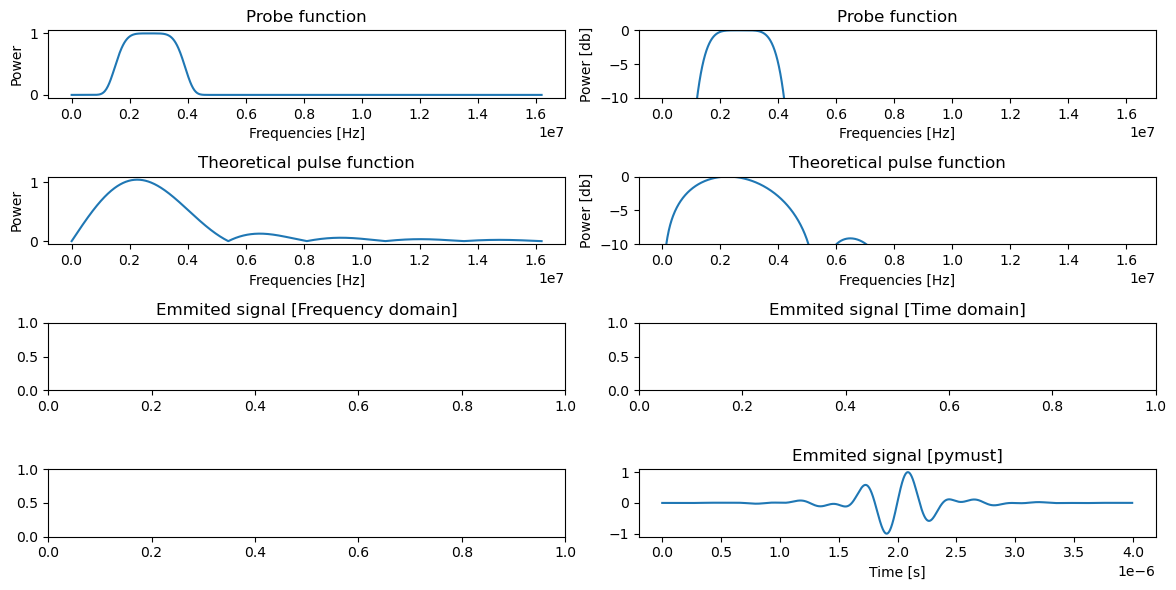

In [11]:
# This are the parameters that you will need to modify
param_single_element.TXnow = 1 # To emmit several pulses
param_single_element.fc = 2.7e6
param_single_element.bandwidth = 76  # The bandwidth is expressed as a percentage of the central frequency, and can go from 0 to 200 (values greater than 200 would reach the 0 frequency)



freqs = np.linspace(0,  6 * param_single_element.fc, 1000) #Plot only the spectrum between 0 and 3 times the central frequency
df = freqs[1] - freqs[0]
ws = 2* np.pi * freqs # The probe and actually work with angular  frequencies

probeFunction = param_single_element.getProbeFunction() # A function call that returns a function. This is allowed in Python
pulseFunction = param_single_element.getPulseSpectrumFunction() 

_, fs = plt.subplots(ncols = 2, nrows = 4, figsize =(12, 6)) 


# Probe function

plt.sca(fs[0,0]) # Plot in the first figure of the grid
plt.plot(freqs, probeFunction(ws))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')
plt.title('Probe function')


plt.sca(fs[0,1]) 
plt.plot(freqs, to_dB(np.abs(probeFunction(ws))))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power [db]')
plt.title('Probe function [dB]')
plt.ylim(-10, 0)

# Pulse function

plt.sca(fs[1,0]) 
plt.plot(freqs, np.abs(pulseFunction(ws)))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power')
plt.title('Theoretical pulse function')

plt.sca(fs[1,1]) 
plt.plot(freqs, to_dB(np.abs(pulseFunction(ws))))
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Power [db]')
plt.title('Theoretical pulse function [dB]')
plt.ylim(-10, 0)


# Emmited pulse  - Your computation
# Do the convolution of the probe and pulse functions in the frequency domain, 
emmited_pulse_freq = ...

plt.sca(fs[2, 0]) 
# Here comes the emmited pulse in frequency domain
plt.title('Emmited signal [Frequency domain]')


plt.sca(fs[2, 1]) 
# and transform it to the time domain using the inverse Fourier transform
# EXERCISE


# Emmited pulse  - From pymust
pulse, t = pymust.getpulse(param_single_element)

plt.sca(fs[3, 0]) 
# Here is plotted the theoretical pulse in the time domain, transform the Fourier space to the time domain
plt.title('Emmited signal [Time domain]')

plt.sca(fs[3, 1]) 
# Here is the emmited pulse in frequency domain
plt.plot(t, pulse)
plt.xlabel('Time [s]')
plt.title('Emmited signal [pymust.getpulse]')

plt.tight_layout()

plt.savefig('Figures/s1_ex1.png')

Please, answer these questions regarding the first part of the exercise.

### Exercise 1.1: Theoretical pulse
 
Here we will take a deeper look on the theoretical pulse. Check at the definition of the pulse functions in the code [file param.py, function "getPulseSpectrumFunction", with the setting FreqSweep set to None], and answer the following questions:


1. The theoretical pulse is the combination of two cardinal sinus (sinc) on the pulse spectrum, one centered at +$f_c$, and the other one at -$f_c$. Why are two cardinal sinus needed? Note: you can obtain a single spectrum of a single sinc, and explain what happens when you apply the Fourier transform.

1. Compute the frequency with the maximum power of the emmited pulse. Compare it with the central frequency of the probe. What do you observe? Hint: you can check what is the central frequency of a single cardinal sinus, and the effect of the second cardinal sinus on the main lobe of the first.

1. Compute the inverse Fourier transform of the theoretical pulse to obtain its time-domain representation, and plot it. Describe the shape of the generated pulse, and its approximative duration (to correctly compute the duration of a signal, you should do the envelope detection, which is explained in the next exercise. In this exercise, a gross estimation is enough.).

### Exercise 1.2: Emmited pulse

Here we will look at the emmited pulse, which is the time-domain convolution of the emmited pulse, and the probe function. The probe function is a bandpass filter, and represents the frequency range that the probe can physically emmit, is  which is defined in the frequency domain. The emmited pulse is the convolution of the probe function and the pulse function.

1. To obtain the emmited pulse, convolve the probe and pulse functions (to what operation does it correspond in the frequency domain?), and obtain both its time-domain and frequency domain representations. Compare with the direct result of using the "getpulse" function from the pymust library, which returns the pulse in the time domain.

1. Qualitatively compare the width of the spectras of the theoretical and emmited pulses, and of their duration in the time domain. Which known characteristic of Signal Processing is this related to?


## Part 2: Probe parameters

Real commercial ultrasonic transducer for medical use offer a black-box solution for emmision and image reconstruction, and only allow to vary few of the parameters. This makes them easier to use, but it is not possible to obtain the raw recieved radiofrequency signal, or emmit custom sequences. On the other side, research transduces allow controlling all its emmision parameters from a copmuter, and recover its recieved radiofrequency signal. In this seminar, we will use a computer-based simulator to emulate this setting, and obtain a synthetic recieved signal which we can process. We will focus on the recieved signal, which is obtained via the "simus" function. This function requires the following parameters:
- Definition of the probe: including bandwidth and central frequency of the probe, as in the previous section.
- Positions and reflecting coefficients of the point scatterers. 
- Activation delay (also known as transmit delay - txdelay) for each piezolectrical element of the probe (in this case is simply a vector with a single 0, since there is a single element in the transducer, but it will be explored in next exercise).

Here, you will modify two parameters: the bandwidth (range of pressure that can be emmited by the probe), and the central frequency, which is the main frequency of the signals, and correspond to the natural vibrating frequency of the quartz piezoelectrical element. 

To know more, you can visit (https://verasonics.com/verasonics-transducers/)

### Exercise 1.3: Probe parameters

1. Compute the bandwidth of the resulting pulse (at -6db), and the central frequency (the frequency with more power) of the resulting value. Change the central and bandwidth of the probe, and report its effect on these measures (try 3 different values for each bw and fc). Compare the results with the theoretical values. Qualitatively discuss the influence of each parameter on the emmited pulse duration [Note: they will not exactly coincide]

1. For some applications, it is beneficial to emmit longer pulses, for instance when doing Doppler. For that, we can emmit several pulses using the parameter TXnow. Change it to 10, and report the effect on the bandwidth and central frequencies of the emmited pulse. Include the plots in your report. 


Hints:
- You can use myfft to do the Fourier transforms
- Beware that somethings are defined in terms of angular moments (ws), and others in frequencys (fs). In order to convert from frequencies to angular moments, you just need to multiply by $2\pi$.
- In order to count the number of a signal above a threshold, you can use the expression np.sum(f > th). In order to get this distance in a physical unit (s, Hz, etc), you need to multiply by the sampling period (1/df) or frequency df.

##### A note on the spatial system of reference

The ultrasound probe is centered at position x = 0, z = 0.

Y coordinates refer to the elevation, and are not used in these tutorials. However, some functions might require to give them a value. In that case, you can use either an array with zeros, or the python empty list []. In most cases, you can also use the python special value *None*.

## Part 3: Received wave

In ultrasound imaging, the emmited pulse interacts with matter. The main interactions are:

- Scatter reflection
- Specular reflection
- Attenuation (absortion)


 Scatter and specular reflections generate echo waves that will go back to the emmiter. In this seminars, we will focus on point scatterers, which are small irregularities of approximately the size of the wavelength with high acoustic reflectivity that will produce a spherical wave when hit by the emmited pressure wavw. The waves will travel backward, and hit the probe, transmitting part of its mechanical energy to the piezoelectrical element which will generate an electrical signal that is registered. In MUST, specular reflections or second order reflections are not considered. The other type of interaction is attenuation, which is the loss of energy of the wave as it travels through the medium. This is due to the conversion of mechanical energy to heat, and is proportional to the distance travelled by the wave.

 In this section, we will use the simulator in pymust (simus call) to generate the recieved signal. We need to specify the position of the scatterers, the probe parameters, and the transmit delays (they are only relevant for probes with many elements, we will see them in detail in the next practice)



Remember from theory that when there is a single scatterer at distance $d$ from the probe, if we emmit a signal $e(t)$, then, the recieved signal will $r(t) = e(t - 2\cdot d/c)$, since we will recieve the same signal, just delayed by the time needed for the pressure wave to reach the scatterer, and come back (to be completely accurate, the recieved signal will also be filtered by the probe function, but since it is roughly af band-pass filter, that has been already applied in the emmision, its effect is small).


### Example of simulating an emmited pulse, and recording the echo done in pyMUST using the simus function
Take a look to this code

Text(0.5, 0, 'Time [s]')

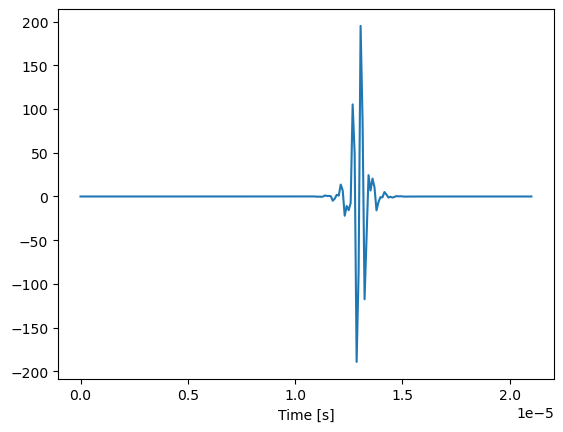

In [9]:
# Define the properties of the scatterer, need to define the x and z position of the scatterer (z is the depth, x is the lateral position with respect to the probe), and the reflecting coefficient RC
xScatterers = np.array([0])
zScatterers = np.array([1e-2])
RCScatterers = np.array([1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = np.array([0]).reshape(1,1)

param_single_element.c = 1540

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param_single_element)
fs = param_single_element.fs # Sampling frequency
t = np.arange(RF.shape[0]) / fs # Time vector
nSamples = RF.shape[0] 
#t = ..  # Complete the time vector,
# RF is a matrix, since in most interesting cases, we will have a channel for each element of the transducer array, but here we will only have one element

#TODO: plot the 
plt.plot(t, RF[:,0])
plt.xlabel('Time [s]')

### Part 3.1 Recieved wave - attenuation and distance

Here we will see the effect of the distance from the scatterer to the probe, in terms of the recieved radiofrequency signal. We will investigate this in the presence of attenuation, which accounts for the energy loss of the signal when it traverses the media. 


A code is given, that you'll need to complete, by  adding the Fourier transform of the signal. This code displays the signal for several scatterers at different positions from the probe.

Finally, you will use the tgc function, which recieves a RF vector, and returns, as a first parameter, the signal after applying time-gain-compensation (it estimates the loss in energy, assuming an exponential model in time, as a signal that travels longer has been more attenuated), and as a second parameter the information on the estimated expontial.

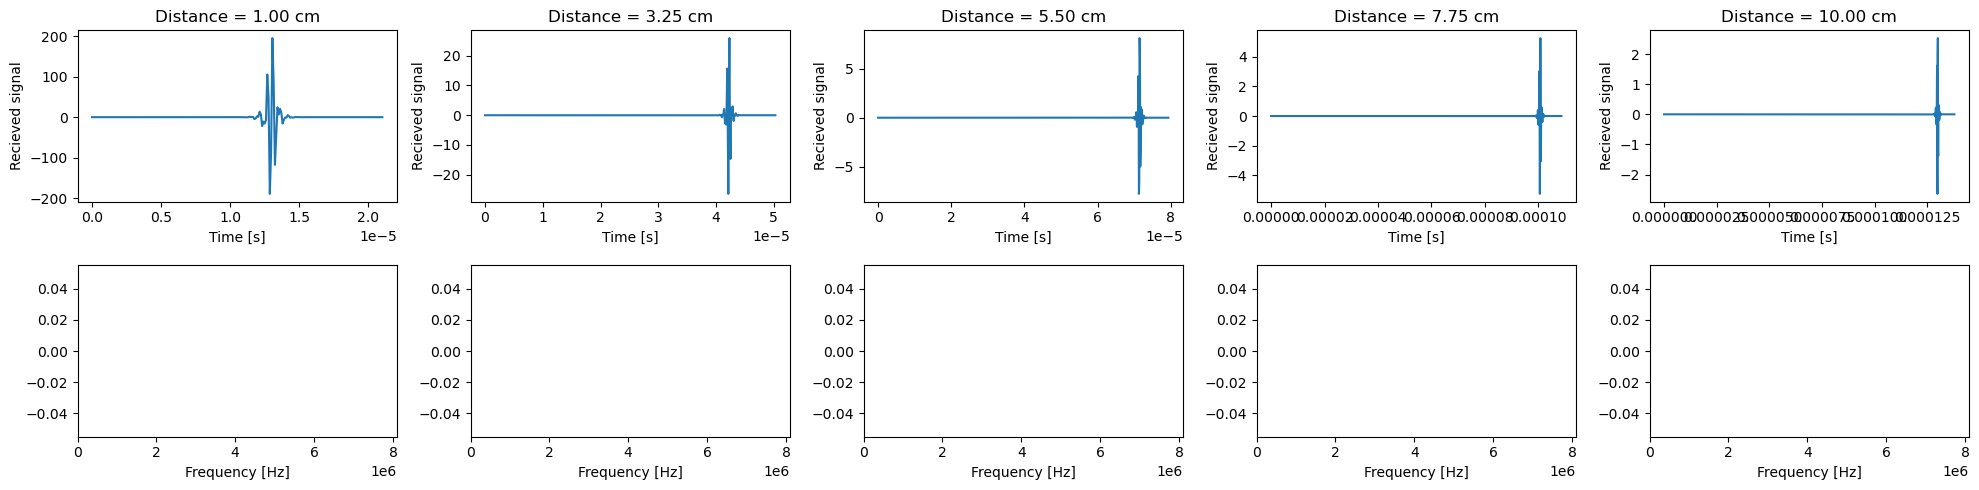

In [10]:
xScatterers = np.array([0])
zScatterers = np.array([1e-2])
RCScatterers = np.array([1])

# Define the activation delays, this will be important when we will have more complex transducers
activationDelaysTX = np.array([0]).reshape(1,1)

param_single_element.c = 1540



_, fs = plt.subplots(ncols = 5, nrows = 2, figsize = (20, 5))

distances = np.linspace(1e-2, 1e-1, num = 5)
for idx, f in np.ndenumerate(fs):
    i,j = idx[0], idx[1]
    if  i == 1:
        continue
    zScatterers = np.array([distances[j]]) # TODO: Change something that depends on i
    
    RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers,  activationDelaysTX, param_single_element)
    t = np.arange(RF.shape[0]) / param_single_element.fs  # param_single_element.fs is the sampling frequency, needed to go from sample number to time

    #TODO: compute the spectra of the radiofrequency using the Fourier transform. You can use my_fft defined above
    RF_spectrum, f = np.zeros(RF.shape[0], dtype = np.complex128), np.zeros_like(t)

    # Plot the signal
    plt.sca(fs[i,j])
    plt.plot(t, RF[:, 0])
    plt.xlabel('Time [s]')
    plt.ylabel('Recieved signal')
    plt.title('Distance = {:.2f} cm'.format(distances[j]*100))
    
    # If not done anything, each of these plot will have its own scale on the x and y axis. Youcan control this with xlim and ylim 

    #TODO: uncomment the following line to set the range of the plots to be equal in all subplots. 
    # You have to give an approppriate value so that all plots have the same scale in the x and y axis() Hint: you can use a hardcoded value)
    # plt.xlim(0, tMax)
    # plt.ylim (-vMax, vMax)

    # Plot the spectra
    plt.sca(fs[i + 1,j])
    plt.tight_layout()
    plt.plot(f, np.abs(RF_spectrum))
    plt.xlabel('Frequency [Hz]')
    plt.xlim(0, 3* param_single_element.fc)
plt.savefig('Figures/s1_ex3.png')

### Exercise 1.4

1. For each distance, compute the approximate time delay between emmision (at 0s) and the time the  value of the . What is the theoretical relation of the (approximate) recieving time of the pulse, and the distance to the scatterer? [Hint: to compute the index of the maximum element in an array, you can use np.argmax]

1. Complete the previous code to plot the frequency domain of the recieved signal for each distance (line 24). Without attenuation, what do you observe with the shape of the frequency, when compared to the emmited signal in the previous exercises?

1. Add the attenuation, and repeat the previous experiment.

1. Include time-gain compensation (pymust.tgc, only use the first return parameter). What effect do you observe in the recieved intensity? and the spectrum?

## Several scatterers

Now we will use the simus function with several scatterers, and study the recieved signal, which now will be composed of several pulses.

For this, we will use demodulation, which is removing the high frequencies around the central frequency to obtain the envelope of the signal. This is done by multiplying the signal by a complex sinus with the same frequency as the central frequency of the signal. The resulting signal is a complex-valud signal called in-phase/quadrature (IQ), and is obtained using the function rf2iq. The original radiofrequency signal, and either the central frequency or the probe parameters need to be provided. In general, the IQ signal will allow an easier analysis of the signal.

In [31]:
xScatterers = np.array([0, 0,np.sqrt(2)*1e-2, - np.sqrt(2)*1e-2,  0])
zScatterers = np.array([1e-2, 2e-2, np.sqrt(2) * 1e-2, np.sqrt(2) * 1e-2, 2.075e-2])
RCScatterers = np.ones(5) # There are 5 scatterers
activationDelaysTX = np.array([0]).reshape(1,1)

RF, _ = pymust.simus(xScatterers, zScatterers, RCScatterers, activationDelaysTX, param_single_element)
# For the students to do
IQ =  pymust.rf2iq(RF, param_single_element)  #...#  TODO: use the pymust rf2iq function with the correct paramters
t = np.arange(RF.shape[0]) / param_single_element.fs # param_single_element.fs is the sampling frequency, needed to go from sample number to time


In [32]:
(1540 * (1e-5*1.4) /2)* 100

1.078

Text(0.5, 0, 'Time [s]')

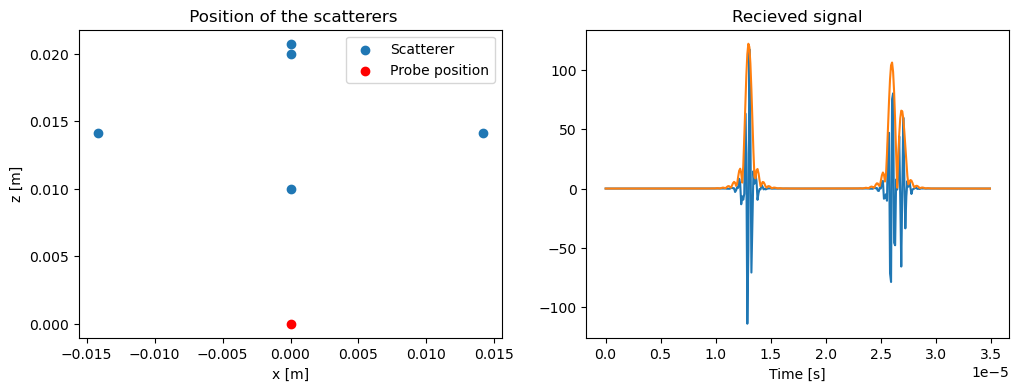

In [33]:
# Here is a plot
_, (f1, f2) = plt.subplots(ncols = 2, figsize = (12, 4))
plt.sca(f1)
plt.scatter(xScatterers, zScatterers, label = 'Scatterer')
plt.scatter([0], [0], c = 'r', label = 'Probe position') # The probe is located here
plt.title (' Position of the scatterers')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend()

plt.sca(f2)
plt.plot(t, RF.flatten())
plt.plot(t, np.abs(IQ).flatten())
plt.title('Recieved signal')
plt .xlabel('Time [s]')


### Exercise 1.5 :

1. Run the following simulation, and display the radiofrequency and  the I/Q demodulated signals (absolute value). How many peaks do you observe, and at which delay (considering its maximal power point in the demodulated signal)?

1. Based on the delay from transmit to recieve each peak, compute the distance of the scatterer to the probe. (Same as question 3 in Exercise 3)

1. Why the number of peaks is not equal to the number of scatterers? 

1. Set the probe bandwidth to 10%. How many peaks can you observe now? Why?